In [1]:
import nltk
import glob
import os
import pandas as pd
import xml.etree.ElementTree as ET
import re
from bs4 import BeautifulSoup as bs
from bs4 import BeautifulStoneSoup
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


In [2]:
def read_file(file_path = "sentiment_data/electronics", file_name = "negative.review"):
    files = glob.glob(file_path)
    data = []
    labels = {}
    sentiment = file_name.split(".")[0]
    review_file = os.path.join(file_path, file_name)
    file = glob.glob(review_file)[0]

    with open(file) as review:
        xml_string = review.read()
        soup = bs(xml_string)

        for i in soup.find_all('review_text'):
            text = bs(i.get_text())
            data.append(text.get_text())
    return data

def create_dataframe(dir_name):
    final_data = []
    for filename in ['positive.review', 'negative.review']:
        data = read_file(file_path=dir_name, file_name=filename)
        sentiment_val = 1 if filename.split(".")[0] == 'positive' else 0
        final_data.append({"review" : data, "sentiment" : sentiment_val})

    df = pd.DataFrame().from_dict(final_data[0])
    df2 = pd.DataFrame().from_dict(final_data[1])
    df = df.append(df2)
    return df        

In [446]:
def calculate_accuracy(test_pred, y_test):
    true_positive = 0;
    true_negative = 0;
    false_positive = 0;
    false_negative = 0;
    correct = 0
    for ind, i in enumerate(y_test.iteritems()):        
        if(i[1] == 1 and test_pred[ind] == 1):
                true_positive += 1

        if(i[1] == 1 and test_pred[ind] == 0):
                true_negative += 1

        if(i[1] == 0 and test_pred[ind] == 0):
                false_positive += 1

        if(i[1] == 0 and test_pred[ind] == 1):
                false_negative += 1

    print("True Positive : " , true_positive)
    print("True Negative : " , true_negative)
    print("false Positive : " , false_positive)
    print("false Negative : " , false_negative)
    
    

    true_prob = true_positive/(true_positive + true_negative)
    false_prob = false_positive/(false_positive + false_negative)
    accuracy = (true_prob + false_prob)/2
    
    print(accuracy)
    result_dict = {"true positive " : true_positive, "true negative" : true_negative, "false positive":false_positive, "false negative":false_negative}
    accuracy_dict = {"accuracy" : accuracy}
#     return accuracy_dict, result_dict
    

In [253]:
class MultinomialTFIDF:
    def __init__(self):
        self.clf_tf_vect = MultinomialNB()
        self.tf_vectorizer = TfidfVectorizer(min_df = 1, max_df = 0.8, ngram_range=(1,3), stop_words = 'english')
        self.count_vect = CountVectorizer(min_df = 1, max_df = 0.8, ngram_range=(1,3), stop_words = 'english')

    def vectorize_dataset(self, dir_name, select_vectorizer):        
#         Create a dataframe with reviews and its sentiment
        if(select_vectorizer == "count"):
            self.vectorizer = self.count_vect
        else:
            self.vectorizer= self.tf_vectorizer
        
        df = create_dataframe(dir_name)
        
        X= df.loc[:, 'review']
        Y= df.loc[:, 'sentiment']

#         Split the data into training set and test set for validation
        x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
        tf = self.vectorizer.fit_transform(X)

        tf_columns = list(self.vectorizer.fit(X).vocabulary_.keys())
        
        df31 = pd.DataFrame(tf.toarray(), columns=tf_columns)
        
        df31['sentiment'] = Y.tolist()
        self.XT_train, self.XT_test, self.YT_train, self.YT_test = train_test_split(df31.iloc[:, :-1], df31.iloc[:, -1], test_size = 0.2, random_state = 0)
        

    def create_multinomial_tfidf(self):
        self.clf_tf_vect.fit(self.XT_train, self.YT_train)

    def test_multinomial_tfidf(self):
        test = self.clf_tf_vect.predict(self.XT_test)
        return test
    
    def get_vectorizer(self):
        return self.vectorizer

    def predict(self, sentence):
#         list_sentence = []
#         list_sentence.append(sentence)
        pred = self.clf_tf_vect.predict(sentence)
        return pred

In [318]:
def plot_confusionmatrix(y_pred, t_test):
    cm = confusion_matrix(y_pred, y_test)
    title = "Accuracy Testing"

    classes = ["Negative", "Positive"]

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[1]), range(cm.shape[0])):
        plt.text(j, i, format(cm[j, i], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


In [254]:
clas = MultinomialTFIDF()
dir_name = "sentiment_data/electronics"
clas.vectorize_dataset(dir_name, "count")
clas.create_multinomial_tfidf()

In [255]:
vectorizer = clas.get_vectorizer()
test_review = ["This product is not bad",]
vectorized_review = vectorizer.transform(test_review)

clas.predict(vectorized_review)

array([0])

In [256]:
test = clas.test_multinomial_tfidf()

In [257]:
calculate_accuracy(test, y_test)

True Positive :  161
True Negative :  39
false Positive :  163
false Negative :  37
0.81


# VECTORIZERS

In [273]:
dir_name = "sentiment_data/electronics"
df = create_dataframe(dir_name)
X= df.loc[:, 'review']
Y= df.loc[:, 'sentiment']

x_train, x_test,y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

# Count vectorizer

In [274]:
count_vect = CountVectorizer(min_df = 1, max_df = 0.8, ngram_range=(1,3))
tf_C_train = count_vect.fit_transform(x_train)
tf_C_test = count_vect.transform(x_test)

# Tfidf Vectorizer

In [275]:
tfidf_vect = TfidfVectorizer(min_df = 1, max_df = 0.8, ngram_range=(1,3))
tf_T_train = tfidf_vect.fit_transform(x_train)
tf_T_test = tfidf_vect.transform(x_test)

# Probablistic Model using mulinomial bayes theurom

In [444]:
multinomial_BOW = MultinomialNB()
multinomial_BOW.fit(tf_C_train, y_train)
multinomial_BOW_test = multinomial_BOW.predict(tf_C_test)

# Calculating multinomial accuracy using count vectorizer

True Positive :  170
True Negative :  30
false Positive :  173
false Negative :  27
0.8574999999999999
None


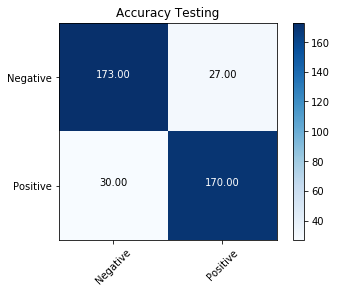

In [447]:
print(calculate_accuracy(multinomial_BOW_test, y_test))
plot_confusionmatrix(multinomial_BOW_test, y_test)

In [448]:
test_review = ["this mobile has nice battery life and good overall performance",]
vectorized_review = count_vect.transform(test_review)
multinomial_BOW.predict(vectorized_review)

array([1])

# Using multinomial naive bayes and tfidf

In [449]:
multinomial_TF = MultinomialNB()
multinomial_TF.fit(tf_T_train, y_train)
multinomial_BOW_test = multinomial_TF.predict(tf_T_test)

True Positive :  162
True Negative :  38
false Positive :  185
false Negative :  15
0.8675
None


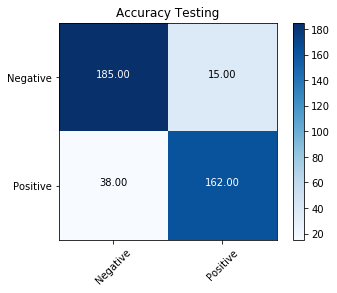

In [450]:
print(calculate_accuracy(multinomial_BOW_test, y_test))
plot_confusionmatrix(multinomial_BOW_test, y_test)

In [281]:
test_review = ["I donot like this mobiles camera",]
vectorized_review = tfidf_vect.transform(test_review)
multinomial_TF.predict(vectorized_review)

array([1])

# Using Decision tree and tfidf

In [282]:
# using decision tree
from sklearn import tree
tree_classifier = tree.DecisionTreeClassifier()

tree_classifier.fit(tf_T_train, y_train.tolist())
decision_output = tree_classifier.predict(tf_T_test)

True Positive :  136
True Negative :  64
false Positive :  123
false Negative :  77
0.6475


True Positive :  136
True Negative :  64
false Positive :  123
false Negative :  77
0.6475
None


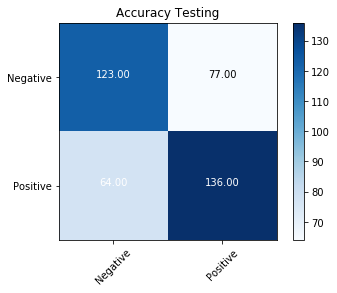

In [329]:
print(calculate_accuracy(decision_output, y_test))
plot_confusionmatrix(decision_output, y_test)

In [283]:
sentence = ["I do not like this mobile",]
sentence = tfidf_vect.transform(sentence)
tree_classifier.predict(sentence)

array([0])

# Using support vector machines and tfidf

In [284]:
# using Linear support vector machine
classifier_liblinear = svm.LinearSVC()
classifier_liblinear.fit(tf_T_train, y_train)
prediction_liblinear = classifier_liblinear.predict(tf_T_test)

True Positive :  172
True Negative :  28
false Positive :  176
false Negative :  24
0.87
None


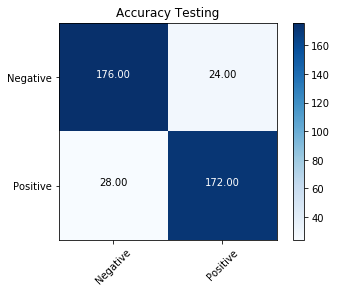

In [319]:
print(calculate_accuracy(prediction_liblinear, y_test))
plot_confusionmatrix(prediction_liblinear, y_test)

True Positive :  172
True Negative :  28
false Positive :  176
false Negative :  24
0.87
True Positive :  136
True Negative :  64
false Positive :  123
false Negative :  77
0.6475
True Positive :  170
True Negative :  30
false Positive :  173
false Negative :  27
0.8574999999999999


True Positive :  172
True Negative :  28
false Positive :  176
false Negative :  24
0.87
True Positive :  136
True Negative :  64
false Positive :  123
false Negative :  77
0.6475
True Positive :  170
True Negative :  30
false Positive :  173
false Negative :  27
0.8574999999999999


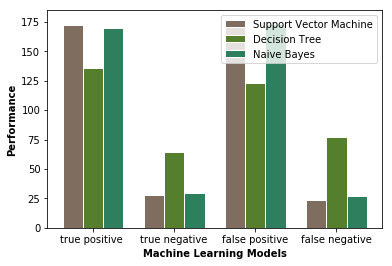

In [443]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25

support_vector_a, support_vector_r  = calculate_accuracy(prediction_liblinear, y_test)
decision_tree_a, decision_tree_r = calculate_accuracy(decision_output, y_test)
naive_bayes_a, naive_bayes_r = calculate_accuracy(multinomial_BOW_test, y_test)
 
# set height of bar
sv_bars = list(support_vector_r.values())
dt_bars = list(decision_tree_r.values())
nb_bars = list(naive_bayes_r.values())
 
# Set position of bar on X axis
pos1 = np.arange(len(bars1))
pos2 = [x + barWidth for x in pos1]
pos3 = [x + barWidth for x in pos2]
 
# Make the plot
plt.bar(pos1, sv_bars, color='#7f6d5f', width=barWidth, edgecolor='white', label='Support Vector Machine')
plt.bar(pos2, dt_bars, color='#557f2d', width=barWidth, edgecolor='white', label='Decision Tree')
plt.bar(pos3, nb_bars, color='#2d7f5e', width=barWidth, edgecolor='white', label='Naive Bayes')
 
# Add xticks on the middle of the group bars
plt.xlabel('Machine Learning Models', fontweight='bold')
plt.ylabel('Performance', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(support_vector_r.keys()))
 
# Create legend & Show graphic
plt.legend()
plt.show()


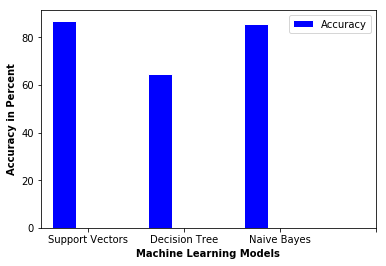

In [440]:
import numpy as np
import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.25

# set height of bar
sv_bars = list(support_vector_a.values())[0]
dt_bars = list(decision_tree_a.values())[0]
nb_bars = list(naive_bayes_a.values())[0]

bar = [sv_bars * 100, dt_bars * 100, nb_bars * 100]
 
# Set position of bar on X axis
pos = np.arange(len(bar))
 
# Make the plot
plt.bar(pos, bar, color='b', width=barWidth, edgecolor='white', label='Accuracy')

 
# Add xticks on the middle of the group bars
plt.xlabel('Machine Learning Models', fontweight='bold')
plt.ylabel('Accuracy in Percent', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], list(["Support Vectors", "Decision Tree", "Naive Bayes"]))
 
# Create legend & Show graphic
plt.legend()
plt.show()